In [1]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# Your module
from spectrum_monitor import WelchConfig, SpectrumModelTrainer, ModelPack, SpectrumMonitor

# (If you pasted save_model_card + plot_snapshot_result in separate files, import them here;
# otherwise we'll define them in later cells.)
DATA_DIR = Path("data")
MODEL_OUT = Path("monitor_pack_v1_fc98_dt0p01_n8192_test.npz")
CARD_OUT  = Path("monitor_pack_v1_fc98_dt0p01_n8192.model_card.json")

print("DATA_DIR exists:", DATA_DIR.exists(), DATA_DIR.resolve())

DATA_DIR exists: True D:\kl_psd\data


In [7]:
def load_iq_files(folder: Path, indices, pattern: str):
    xs = []
    for k in indices:
        fp = folder / pattern.format(k=k)
        x = np.load(fp)
        x = np.asarray(x).reshape(-1)
        if not np.iscomplexobj(x):
            raise ValueError(f"{fp.name} is not complex IQ.")
        xs.append(x)
    return xs

pattern = "Samples 88 and 108MHz,time to read 0.01s, sample #{k}.npy"
indices = list(range(100))

xs = load_iq_files(DATA_DIR, indices, pattern)[-5:]
print("Loaded snapshots:", len(xs), " | IQ length:", len(xs[0]))

Loaded snapshots: 5  | IQ length: 200000


In [8]:
welch_cfg = WelchConfig(
    fc_hz=98e6,
    dt_acq_s=0.01,
    nperseg=8192,
    noverlap=4096,
    window="hann",
    detrend=False,
    average="mean",
)

welch_cfg

WelchConfig(fc_hz=98000000.0, dt_acq_s=0.01, nperseg=8192, noverlap=4096, window='hann', detrend=False, average='mean')

In [15]:
trainer = SpectrumModelTrainer(random_seed=0)

model = trainer.train_from_iq(
    xs=xs,
    welch_cfg=welch_cfg,
    R=20,
    quiet_frac=0.25,
    fit_kernel=True,
    fit_indices=(0, 25, 50, 75),
    n_restarts=3,
    version="monitor_pack_v1_fc98_dt0p01_n8192",
)

print("Trained:")
print("  M =", model.f_hz.size)
print("  R =", model.R)
print("  Phi shape =", model.Phi_KL.shape)
print("  sigma_eps =", model.kernel_params.sigma_eps)

Trained:
  M = 8192
  R = 20
  Phi shape = (8192, 20)
  sigma_eps = 4.399449386070043e-13


In [16]:
model.save(MODEL_OUT)
print("Saved model:", MODEL_OUT.resolve())

Saved model: D:\kl_psd\monitor_pack_v1_fc98_dt0p01_n8192.npz


In [17]:
import json
from dataclasses import asdict

def save_model_card(model, path: Path) -> None:
    f = np.asarray(model.f_hz).reshape(-1)
    w = np.asarray(model.w).reshape(-1)
    M = int(f.size)
    R = int(model.R)

    df_stats = {}
    if M >= 2:
        df = np.diff(f)
        df_stats = dict(
            df_hz_mean=float(np.mean(df)),
            df_hz_min=float(np.min(df)),
            df_hz_max=float(np.max(df)),
        )

    card = dict(
        schema_version="model_card_v1",
        model_version=str(model.version),
        contracts=dict(
            welch=asdict(model.welch),
            frequency_grid=dict(
                M=M,
                f_hz_start=float(f[0]),
                f_hz_stop=float(f[-1]),
                **df_stats,
                ordering="fftshifted (centered), RF = fc + f_bb",
            ),
            units=dict(
                psd="linear (power/Hz), not dB",
                noise_floor_snf="linear PSD (power/Hz)",
                sigma_eps="linear PSD (power/Hz) likelihood scale",
            ),
        ),
        basis=dict(
            R=R,
            Phi_KL_shape=[int(model.Phi_KL.shape[0]), int(model.Phi_KL.shape[1])],
            weights_shape=[int(w.shape[0])],
        ),
        kernel_params=asdict(model.kernel_params),
        online_defaults=dict(
            p_fa_bin=float(model.p_fa_bin),
            pi0=float(model.pi0),
            snf_estimation="quiet_frac median in lowest-quantile PSD bins (unless snf provided)",
        ),
        notes=[
            "Online Welch configuration must match this card exactly.",
            "If the online IQ produces a different frequency grid, resample PSD to f_hz or reject.",
        ],
    )

    path.write_text(json.dumps(card, indent=2))
    print("Wrote model card:", path.resolve())

save_model_card(model, CARD_OUT)

Wrote model card: D:\kl_psd\monitor_pack_v1_fc98_dt0p01_n8192.model_card.json


In [18]:
model2 = ModelPack.load(MODEL_OUT)
print("Loaded model version:", model2.version)
print("Phi shape:", model2.Phi_KL.shape)


Loaded model version: monitor_pack_v1_fc98_dt0p01_n8192
Phi shape: (8192, 20)


In [19]:
mon = SpectrumMonitor(model2, enable_kf=False)  # keep lightweight

x0 = xs[0]
res0 = mon.infer_snapshot(
    x0,
    snf=None,            # let it estimate noise floor
    quiet_frac=0.25,
)

print("Emitters found:", len(res0.emitters))
res0.emitters[:3]


Emitters found: 6


[{'f_start_hz': 88922851.5625,
  'f_stop_hz': 90416992.1875,
  'bw_hz': 1494140.625,
  'f_peak_hz': 89618652.34375,
  'peak_psd': 2.1467758868402495e-11,
  'f_centroid_hz': 89647402.43867368,
  'i_start': 378,
  'i_stop': 990},
 {'f_start_hz': 91066406.25,
  'f_stop_hz': 92309082.03125,
  'bw_hz': 1242675.78125,
  'f_peak_hz': 91674316.40625,
  'peak_psd': 1.1384137973370094e-11,
  'f_centroid_hz': 91684095.90361242,
  'i_start': 1256,
  'i_stop': 1765},
 {'f_start_hz': 94589355.46875,
  'f_stop_hz': 96532714.84375,
  'bw_hz': 1943359.375,
  'f_peak_hz': 95595214.84375,
  'peak_psd': 3.839858825362178e-11,
  'f_centroid_hz': 95579695.94570862,
  'i_start': 2699,
  'i_stop': 3495}]

In [20]:
def to_db(x: np.ndarray, floor: float = 1e-30) -> np.ndarray:
    x = np.asarray(x)
    return 10.0 * np.log10(np.maximum(x, floor))

def plot_snapshot_result(
    res,
    title: str = "Spectrum Monitor Snapshot",
    show_posterior_std: bool = True,
    db: bool = True,
):
    f_mhz = res.f_hz / 1e6

    y_welch = res.psd_welch
    y_mu = res.mu_psd
    y_std = np.sqrt(np.maximum(res.sigma_psd_diag, 0.0))

    if db:
        y_welch_p = to_db(y_welch)
        y_mu_p = to_db(y_mu)
        y_hi = to_db(y_mu + 2.0 * y_std) if show_posterior_std else None
        y_lo = to_db(np.maximum(y_mu - 2.0 * y_std, 1e-30)) if show_posterior_std else None
        y_tau = to_db(np.full_like(y_mu, res.tau_bin))
        ylab = "PSD (dB)"
    else:
        y_welch_p = y_welch
        y_mu_p = y_mu
        y_hi = (y_mu + 2.0 * y_std) if show_posterior_std else None
        y_lo = np.maximum(y_mu - 2.0 * y_std, 0.0) if show_posterior_std else None
        y_tau = np.full_like(y_mu, res.tau_bin)
        ylab = "PSD (linear)"

    fig, ax = plt.subplots(figsize=(12, 5))

    ax.plot(f_mhz, y_welch_p, label="Welch PSD")
    ax.plot(f_mhz, y_mu_p, label="Posterior mean PSD")

    if show_posterior_std and (y_hi is not None) and (y_lo is not None):
        ax.fill_between(f_mhz, y_lo, y_hi, alpha=0.2, label="±2σ (marginal)")

    ax.plot(f_mhz, y_tau, linestyle="--", label="τ (bin threshold)")

    # Emitters shaded
    ymax = np.max(y_mu_p)
    for k, em in enumerate(res.emitters):
        f0 = em["f_start_hz"] / 1e6
        f1 = em["f_stop_hz"] / 1e6
        ax.axvspan(f0, f1, alpha=0.15)

        fp = em["f_peak_hz"] / 1e6
        idx = int(np.argmin(np.abs(f_mhz - fp)))
        ax.plot([fp], [y_mu_p[idx]], marker="o")

        bw_khz = em["bw_hz"] / 1e3
        peak_psd = em["peak_psd"]
        peak_txt = f"{10*np.log10(max(peak_psd,1e-30)):.1f} dB" if db else f"{peak_psd:.3g}"
        ax.text(
            0.5 * (f0 + f1),
            ymax,
            f"Em{k+1}: {bw_khz:.1f} kHz, peak {peak_txt}",
            ha="center",
            va="bottom",
            fontsize=9,
        )

    snf_txt = f"snf_used={to_db(np.array([res.snf_used]))[0]:.1f} dB" if db else f"snf_used={res.snf_used:.3g}"
    ax.text(0.01, 0.01, snf_txt, transform=ax.transAxes, fontsize=9, va="bottom")

    ax.set_title(title)
    ax.set_xlabel("Frequency (MHz)")
    ax.set_ylabel(ylab)
    ax.grid(True, alpha=0.3)
    ax.legend(loc="best")

    return fig, ax


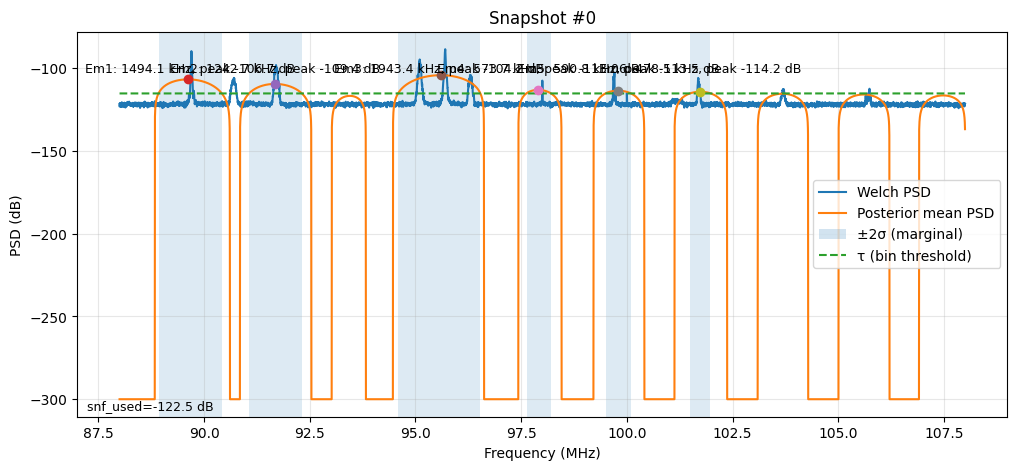

In [21]:
plot_snapshot_result(res0, title="Snapshot #0", show_posterior_std=True, db=True)
plt.show()

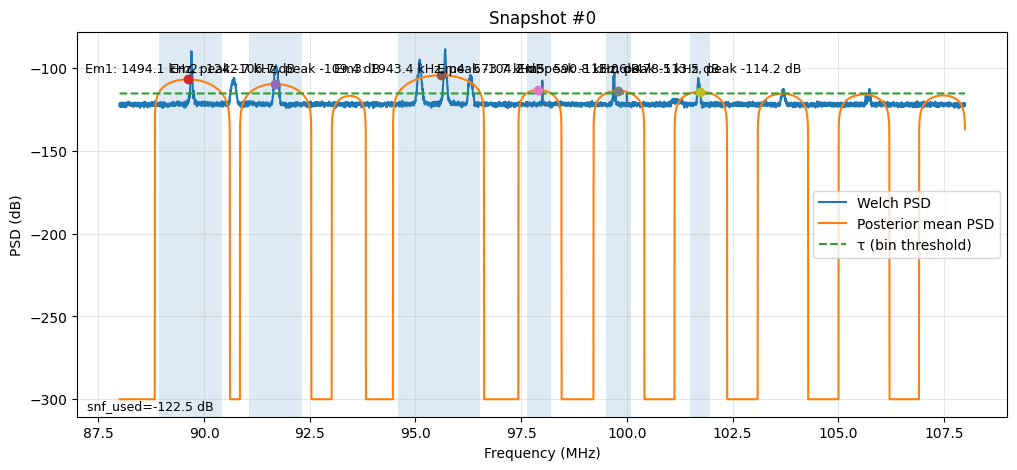

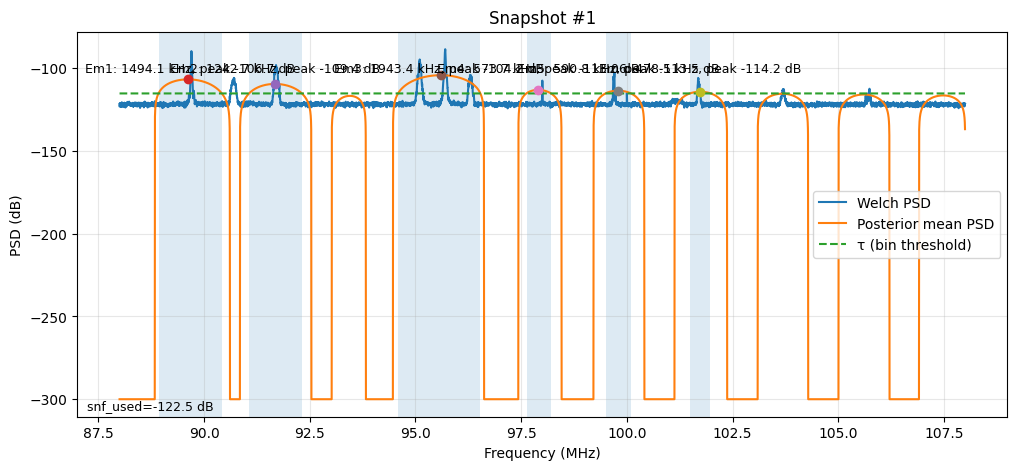

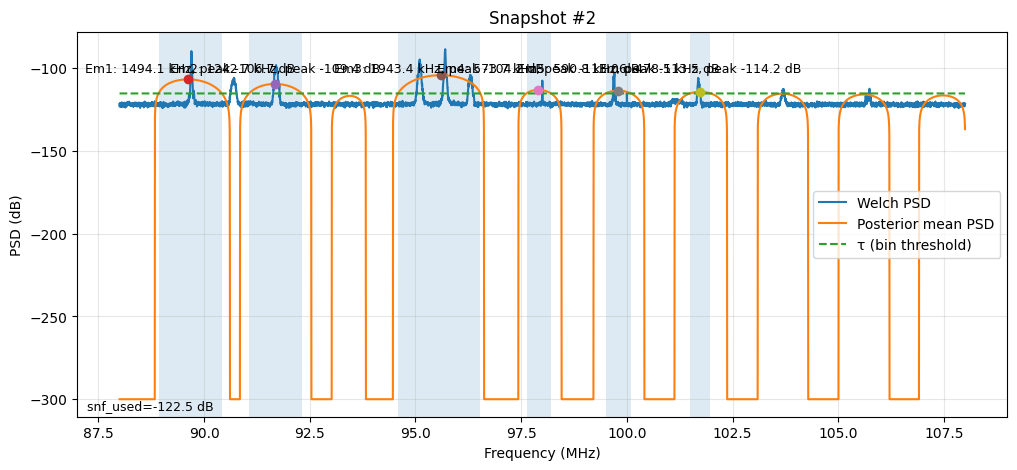

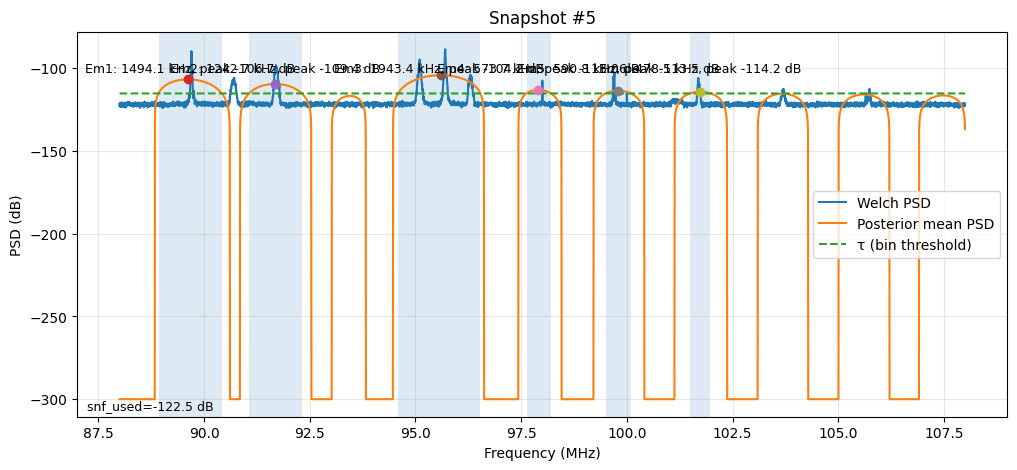

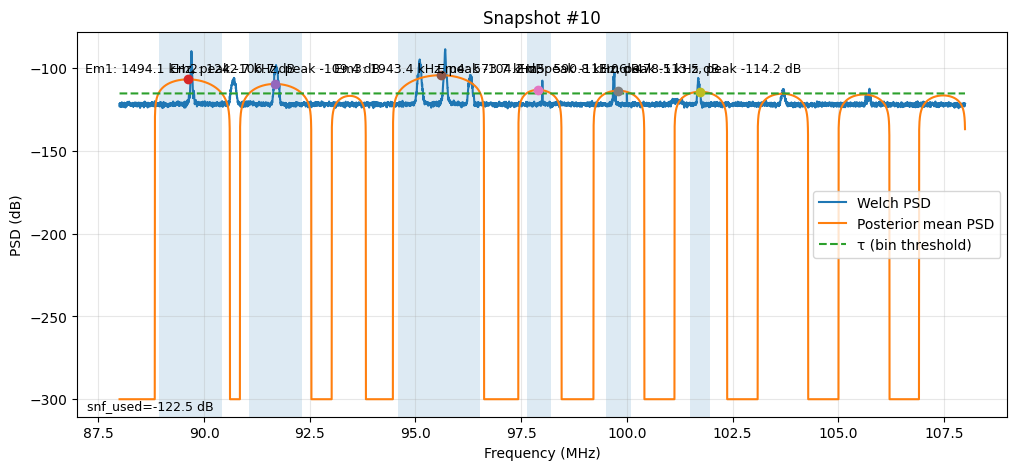

In [22]:
for k in [0, 1, 2, 5, 10]:
    res = mon.infer_snapshot(xs[k], snf=None, quiet_frac=0.25)
    plot_snapshot_result(res, title=f"Snapshot #{k}", show_posterior_std=False, db=True)
    plt.show()

In [ ]:
print("Files to send your partner:")
print(" - spectrum_monitor.py")
print(" -", MODEL_OUT.name)
print(" -", CARD_OUT.name)
print("\nModel card preview:")
print(CARD_OUT.read_text()[:800], "...")

Files to send your partner:
 - spectrum_monitor.py
 - monitor_pack_v1_fc98_dt0p01_n8192.npz
 - monitor_pack_v1_fc98_dt0p01_n8192.model_card.json

Model card preview:
{
  "schema_version": "model_card_v1",
  "model_version": "monitor_pack_v1_fc98_dt0p01_n8192",
  "contracts": {
    "welch": {
      "fc_hz": 98000000.0,
      "dt_acq_s": 0.01,
      "nperseg": 8192,
      "noverlap": 4096,
      "window": "hann",
      "detrend": false,
      "average": "mean"
    },
    "frequency_grid": {
      "M": 8192,
      "f_hz_start": 88000000.0,
      "f_hz_stop": 107997558.59375,
      "df_hz_mean": 2441.40625,
      "df_hz_min": 2441.40625,
      "df_hz_max": 2441.40625,
      "ordering": "fftshifted (centered), RF = fc + f_bb"
    },
    "units": {
      "psd": "linear (power/Hz), not dB",
      "noise_floor_snf": "linear PSD (power/Hz)",
      "sigma_eps": "linear PSD (power/Hz) likelihood scale"
    }
  },
  "basis": {
    "R": 20,
    "Phi_KL_shape": [
   ...


: 